In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from graspologic.inference import latent_distribution_test
from tqdm import tqdm_notebook as tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# corrected = {}
# uncorrected = {}

# for subject1 in np.arange(57):
#     subject1 = subject1 + 1
#     corrected[subject1] = {}
#     uncorrected[subject1] = {}
#     for subject2 in tqdm(np.arange(57)):
#         subject2 = subject2 + 1
#         corrected[subject1][subject2] = {}
#         uncorrected[subject1][subject2] = {}
#         for scan1 in [1, 2]:
#             corrected[subject1][subject2][scan1] = {}
#             uncorrected[subject1][subject2][scan1] = {}
#             for scan2 in [1, 2]:
#                 A = nx.read_graphml(f'../data/DS01216-weighted-directed/subj{subject1}-scan{scan1}.graphml')
#                 B = nx.read_graphml(f'../data/DS00833-weighted-directed/subj{subject2}-scan{scan2}.graphml')

#                 corrected_pval = latent_distribution_test(A, B,
#                                                           test="hsic",
#                                                           metric='gaussian',
#                                                           workers=cpu_count() - 2,
#                                                           size_correction=True).pvalue
#                 uncorrected_pval = latent_distribution_test(A, B,
#                                                           test="hsic",
#                                                           metric='gaussian',
#                                                           workers=cpu_count() - 2,
#                                                           size_correction=False).pvalue

#                 corrected[subject1][subject2][scan1][scan2] = corrected_pval
#                 uncorrected[subject1][subject2][scan1][scan2] = uncorrected_pval

#                 pkl.dump(corrected, open( "../data/corrected_small_large.pkl", "wb" ))
#                 pkl.dump(uncorrected, open( "../data/uncorrected_small_large.pkl", "wb" ))

In [4]:
corrected = pkl.load(open( "../data/real_data_small_large_corrected.pkl", "rb" ))
uncorrected = pkl.load(open( "../data/real_data_small_large_uncorrected.pkl", "rb" ))

In [5]:
same_subject_same_scan_corrected = []
same_subject_diff_scan_corrected = []
diff_subject_diff_scan_corrected = []
same_subject_same_scan_uncorrected = []
same_subject_diff_scan_uncorrected = []
diff_subject_diff_scan_uncorrected = []

for subject1 in np.arange(57):
    subject1 = subject1 + 1
    for subject2 in np.arange(57):
        subject2 = subject2 + 1
        for scan1 in [1, 2]:
            for scan2 in [1, 2]:
                if (subject1 == subject2) and (scan1 == scan2):
                    same_subject_same_scan_corrected.append(corrected[subject1][subject2][scan1][scan2])
                    same_subject_same_scan_uncorrected.append(uncorrected[subject1][subject2][scan1][scan2])
                elif (subject1 == subject2):
                    same_subject_diff_scan_corrected.append(corrected[subject1][subject2][scan1][scan2])
                    same_subject_diff_scan_uncorrected.append(uncorrected[subject1][subject2][scan1][scan2])
                else:
                    diff_subject_diff_scan_corrected.append(corrected[subject1][subject2][scan1][scan2])
                    diff_subject_diff_scan_uncorrected.append(uncorrected[subject1][subject2][scan1][scan2])

In [6]:
len(same_subject_same_scan_corrected), len(same_subject_diff_scan_corrected), len(diff_subject_diff_scan_corrected)

(114, 114, 12768)

In [7]:
len(same_subject_same_scan_uncorrected), len(same_subject_diff_scan_uncorrected), len(diff_subject_diff_scan_uncorrected)

(114, 114, 12768)

## Figure 10

Wilcoxon p-value of differences in p-values for CASE vs. ASE: 7.25095948275856e-08


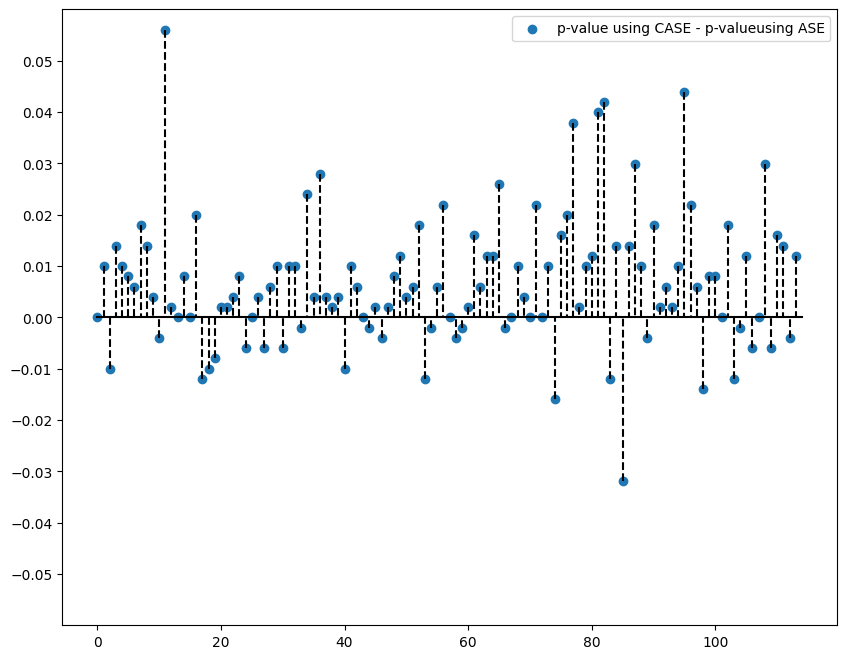

In [8]:
print('Wilcoxon p-value of differences in p-values for CASE vs. ASE: {}'.format(
    stats.wilcoxon(same_subject_same_scan_corrected, same_subject_same_scan_uncorrected, alternative='greater')[1]))

fig1, ax1 = plt.subplots(1, 1, figsize=(10, 8))
ax1.plot([0, 114], [0, 0], color='k')
for i in range(114):
    ax1.plot([i, i],
             [same_subject_same_scan_corrected[i] - same_subject_same_scan_uncorrected[i], 0],
             color='k',
             linestyle='--',
             )
ax1.scatter(np.arange(114),
            np.array(same_subject_same_scan_corrected) - np.array(same_subject_same_scan_uncorrected),
            label='p-value using CASE - p-valueusing ASE')
ax1.legend()
ax1.set_ylim(-0.06, 0.06)
ax1.set_yticks(np.linspace(-0.05, 0.05, 11));
fig1.savefig('../figures/real_data_null',
             bbox_inches='tight', dpi=300);

## Figure 11

In [9]:
comparisons = np.array(same_subject_same_scan_corrected +
                       same_subject_diff_scan_corrected +
                       diff_subject_diff_scan_corrected)
labels = ['same subject same scan'] * 114 + ['same subject diff scan'] * 114 + ['diff subject'] * 12768
histogram_data = pd.DataFrame(data = np.vstack([comparisons, labels]).T,
                              columns=['p-values', 'comparisons'])
histogram_data['p-values'] = histogram_data['p-values'].astype(float)

Mann-Whitney U (one-sided) p-value for same subject same scan vs. same subject diff scan: 0.02038596297491662
Mann-Whitney U (one-sided) p-value for same subject diff scan vs. diff subject: 0.0026478632404536443
Mann-Whitney U (one-sided) p-value for same subject same scan vs. diff subject: 2.0206902648794454e-08


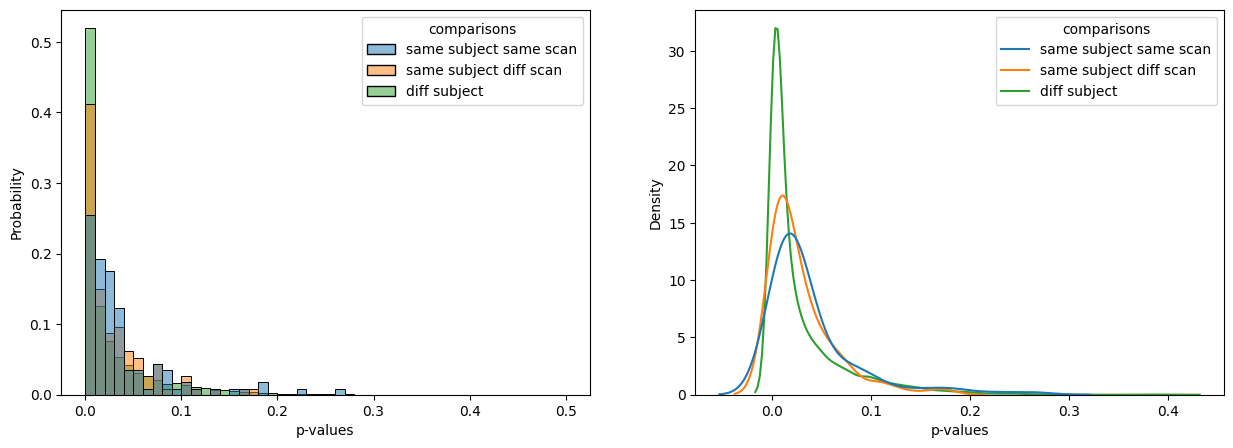

In [10]:
print('Mann-Whitney U (one-sided) p-value for same subject same scan vs. same subject diff scan: {}'.format(
    stats.mannwhitneyu(same_subject_same_scan_corrected,
                       same_subject_diff_scan_corrected,
                       alternative='greater')[1]))
print('Mann-Whitney U (one-sided) p-value for same subject diff scan vs. diff subject: {}'.format(
    stats.mannwhitneyu(same_subject_diff_scan_corrected,
                       diff_subject_diff_scan_corrected,
                       alternative='greater')[1]))
print('Mann-Whitney U (one-sided) p-value for same subject same scan vs. diff subject: {}'.format(
    stats.mannwhitneyu(same_subject_same_scan_corrected,
                       diff_subject_diff_scan_corrected,
                       alternative='greater')[1]))

fig2, (ax21, ax22) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(histogram_data,
             x='p-values',
             hue='comparisons',
             stat='probability',
             binrange=(0.00, 0.50),
             binwidth=(0.01),
             common_norm=False,
             ax=ax21,
            )
sns.kdeplot(histogram_data,
             x='p-values',
             hue='comparisons',
             common_norm=False,
             ax=ax22,
            )
fig2.savefig('../figures/real_data_alternative',
             bbox_inches='tight', dpi=300);